In [1]:
!pip install -U transformers

## Local Inference on GPU
Model page: https://huggingface.co/google/t5-efficient-tiny

⚠️ If the generated code snippets do not work, please open an issue on either the [model repo](https://huggingface.co/google/t5-efficient-tiny)
			and/or on [huggingface.js](https://github.com/huggingface/huggingface.js/blob/main/packages/tasks/src/model-libraries-snippets.ts) 🙏

In [2]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("google/t5-efficient-tiny")
model = AutoModelForSeq2SeqLM.from_pretrained("google/t5-efficient-tiny")

model.gradient_checkpointing_enable()
model.config.use_cache = False

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/628 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/62.3M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [3]:
from datasets import load_dataset

ds = load_dataset("abisee/cnn_dailymail", "3.0.0")

model.safetensors:   0%|          | 0.00/62.3M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [4]:
prefix = "summarize: "
max_source_len = 384
max_target_len = 128

def preprocess(batch):
    inputs = [prefix + x for x in batch["article"]]
    model_inputs = tokenizer(inputs, max_length=max_source_len, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch["highlights"], max_length=max_target_len, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

cols = ds["train"].column_names
tokenized = ds.map(preprocess, batched=True, remove_columns=cols)

train_ds = tokenized["train"].select(range(5000))
eval_ds  = tokenized["validation"].select(range(50))


Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4006: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [5]:
!pip install -q evaluate
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=902953493c205dca462ecdb1eb72de55df42de92a96611bfd78882ea7f74a753
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [6]:
import numpy as np, evaluate
rouge = evaluate.load("rouge")

def _safe_ids(arr, pad_id, vocab_size=None):
    arr = np.array(arr)

    if arr.ndim == 3:
        arr = arr[:, 0, :]

    if arr.dtype.kind != "i":
        arr = arr.astype("int64", copy=False)

    arr[arr < 0] = pad_id
    if vocab_size:
        arr = np.where(arr >= vocab_size, pad_id, arr)
    return arr

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    if isinstance(preds, tuple):
        preds = preds[0]
    pad_id = tokenizer.pad_token_id or 0
    vocab_size = getattr(tokenizer, "vocab_size", None)

    preds  = _safe_ids(preds,  pad_id, vocab_size)
    labels = _safe_ids(np.where(labels != -100, labels, pad_id), pad_id, vocab_size)


    decoded_preds  = tokenizer.batch_decode(preds.tolist(),  skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels.tolist(), skip_special_tokens=True)

    decoded_preds  = [p.strip() for p in decoded_preds]
    decoded_labels = [l.strip() for l in decoded_labels]
    scores = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {k: round(v * 100, 4) for k, v in scores.items()}


In [7]:
from transformers import DataCollatorForSeq2Seq
collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [8]:
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments
)

training_args = Seq2SeqTrainingArguments(
    output_dir="./t5efftiny-cnndm-full",
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_steps=100,
    save_steps=500,
    save_total_limit=2,
    remove_unused_columns=True,
    report_to="none",
    fp16=False,
    predict_with_generate=True,
    generation_max_length=128,
    generation_num_beams=4,
)

In [9]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipython-input-341489654.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
100,6.776600
200,5.044400
300,4.821500
400,4.724400
500,4.537000
600,4.521900
700,4.493600
800,4.391700
900,4.374300
1000,4.329400


TrainOutput(global_step=2500, training_loss=4.440802722167969, metrics={'train_runtime': 198.5777, 'train_samples_per_second': 50.358, 'train_steps_per_second': 12.59, 'total_flos': 169244098560000.0, 'train_loss': 4.440802722167969, 'epoch': 2.0})

In [10]:
trainer.evaluate()

{'eval_loss': 3.1407558917999268,
 'eval_rouge1': 18.009,
 'eval_rouge2': 6.0584,
 'eval_rougeL': 14.8251,
 'eval_rougeLsum': 14.8225,
 'eval_runtime': 14.5452,
 'eval_samples_per_second': 3.438,
 'eval_steps_per_second': 0.894,
 'epoch': 2.0}

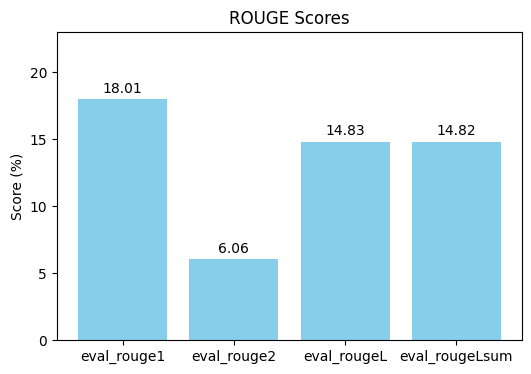

In [12]:
import matplotlib.pyplot as plt

metrics = {
    'eval_loss': 3.1407558917999268,
    'eval_rouge1': 18.009,
    'eval_rouge2': 6.0584,
    'eval_rougeL': 14.8251,
    'eval_rougeLsum': 14.8225,
}

rouge_scores = {k: v for k, v in metrics.items() if 'rouge' in k}

plt.figure(figsize=(6, 4))
plt.bar(rouge_scores.keys(), rouge_scores.values(), color='skyblue')
plt.ylabel("Score (%)")
plt.title("ROUGE Scores")
plt.ylim(0, max(rouge_scores.values()) + 5)

for i, (k, v) in enumerate(rouge_scores.items()):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center')

plt.show()


In [13]:
import os, time, psutil, torch, numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

def pick_texts(n=64):
    try:
        cols = getattr(val_dataset, "column_names", [])
        col = next((c for c in ["input_text","text","article","content","src"] if c in cols), None)
        if col is None: raise KeyError
        xs = [val_dataset[i][col] for i in range(min(n, len(val_dataset)))]
        if not xs: raise KeyError
        return (xs * (n // len(xs) + 1))[:n]
    except Exception:
        return ["This is a short sentence for timing."] * n

def encode(texts):
    enc = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    return {k: v.to(device) for k, v in enc.items()}

@torch.inference_mode()
def bench(bs, repeats=10, warmup=3, max_new_tokens=6, **gen_kwargs):
    texts  = pick_texts(bs)
    inputs = encode(texts)

    max_length = int(inputs["input_ids"].size(1) + max_new_tokens)

    if device.type == "cuda":
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()


    for _ in range(warmup):
        _ = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs.get("attention_mask"),
            max_length=max_length, **gen_kwargs
        )
        if device.type == "cuda": torch.cuda.synchronize()


    ts = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        _ = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs.get("attention_mask"),
            max_length=max_length, **gen_kwargs
        )
        if device.type == "cuda": torch.cuda.synchronize()
        ts.append(time.perf_counter() - t0)


    gpu_cur = gpu_peak = None
    if device.type == "cuda":
        gpu_cur  = torch.cuda.memory_allocated() / (1024**2)      # MB
        gpu_peak = torch.cuda.max_memory_allocated() / (1024**2)  # MB
    cpu_mb = psutil.Process(os.getpid()).memory_info().rss / (1024**2)

    return dict(
        bs=bs,
        avg_s=float(np.mean(ts)),
        gpu_cur_mb=None if gpu_cur is None else round(gpu_cur, 2),
        gpu_peak_mb=None if gpu_peak is None else round(gpu_peak, 2),
        cpu_mb=round(cpu_mb, 2),
    )

def safe_bench(bs, **gen_kwargs):
    try:
        return bench(bs, **gen_kwargs)
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            if device.type == "cuda": torch.cuda.empty_cache()
            return dict(bs=bs, avg_s=None, OOM=True)
        raise


gen_kwargs = dict(num_beams=4, no_repeat_ngram_size=3, length_penalty=0.1,
                  early_stopping=True, eos_token_id=tokenizer.eos_token_id)


b1  = safe_bench(1,  repeats=20, warmup=5, max_new_tokens=6, **gen_kwargs)
b8  = safe_bench(8,  repeats=10, warmup=3, max_new_tokens=6, **gen_kwargs)
b16 = safe_bench(16, repeats=10, warmup=3, max_new_tokens=6, **gen_kwargs)
b32 = safe_bench(32, repeats=10, warmup=3, max_new_tokens=6, **gen_kwargs)

fmt = lambda s: "OOM" if s is None else f"{s*1000:.2f} ms"

print("=== Metrics ===")
print("Average Inference Latency (single input):", fmt(b1["avg_s"]))
print("GPU Memory (Current Allocated):", b1.get("gpu_cur_mb","N/A"), "MB")
print("GPU Memory (Peak Allocated):   ", b1.get("gpu_peak_mb","N/A"), "MB")
print("CPU Memory Usage:", b1.get("cpu_mb","N/A"), "MB")
print("Batch Size 1  Latency:",  fmt(b1["avg_s"]))
print("Batch Size 8  Latency:",  fmt(b8.get("avg_s")))
print("Batch Size 16 Latency:",  fmt(b16.get("avg_s")))
print("Batch Size 32 Latency:",  fmt(b32.get("avg_s")))


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


=== Metrics ===
Average Inference Latency (single input): 217.24 ms
GPU Memory (Current Allocated): 195.11 MB
GPU Memory (Peak Allocated):    197.9 MB
CPU Memory Usage: 4347.21 MB
Batch Size 1  Latency: 217.24 ms
Batch Size 8  Latency: 491.70 ms
Batch Size 16 Latency: 316.80 ms
Batch Size 32 Latency: 283.64 ms
